# <center>Estimation of the Basic Reproduction Number for the Initial Period of the Coronavirus Disease 2019 Epidemic Outbreak in Croatia: Overview</center>

<center>
    Ante Lojic Kapetanovic <br>
    <a href="alojic00@fesb.hr">alojic00@fesb.hr</a> <br>
    Faculty of electrical engineering, mechanical engineering and naval architecture <br>
    University of Split <br>
    Split, Croatia
</center>

**Summary** $-$ This short *essay-with-code* overviews three different methods of estimating the basic reproduction number ($R_0$) for the novel Coronavirus Disease 2019 (COVID-19). First method is performed in a *brute-force* fashion where the expected ratio of secondary infections and the number of current infections is observed. Secondary infections are defined as the total number of infections $n$ time points (most often days) shifted from the currently observed time point. In this case, the main assumption is that the observed population is unvaccinated, without innate immunity, homogeneous and well mixed where no changes in the population size happen over time, i.e. population borders are closed and vital dynamcis are not taken into an account. Outlined assumptions are well aligned with the second approach of estimating $R_0$, which is based on the fitting of the measured data (daily number of infections, recoveries and deaths caused by COVID-19) to the compartmental epidemiological deterministic model, in this case,  Susceptible-Exposed-Infected-Removed (SEIR) and Susceptible-Exposed-Infected-Recovered-Deceased (SEIRD) models, in-detail overview of both models is carried out subsequently in Section 2. Finally, the third method is based on empirical observations of the contact rate which represents the probability of transmitting disease between a susceptible and an infectious individual.

**Keywords** $-$ Coronavirus disease 2019, basic reproduction number, SEIR compartmental model

**Software** $-$ Ubuntu 18.04 LTS, Python 3.7.6, CoroPy package

In [1]:
# LIB IMPORTS

import os
import datetime as dt

from coropy.compartmental_models import SEIRModel
from coropy.compartmental_models import SEIRDModel
import coropy.reproduction_rate as R
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

import plotting

In [2]:
np.random.seed(42)  # for reproducibility of results

In [3]:
plotting.configure()  # for paper-quality plots

In [4]:
# DATA LOAD

DATA_DIR = 'data'
FILE_NAMES = ['1st_wave_data_cro.csv',
              '2nd_wave_data_cro.csv']
FILE_PATHS = [os.path.join(os.pardir, DATA_DIR, FILE_NAMES[0]),
              os.path.join(os.pardir, DATA_DIR, FILE_NAMES[1])]
df_1 = pd.read_csv(FILE_PATHS[0])
first_wave_period = len(df_1)
df_2 = pd.read_csv(FILE_PATHS[1])
df = pd.concat([df_1, df_2[1:-1]], sort=False)

cum_positives = np.cumsum(df.confirmed_positives.values)
cum_recovered = df.estimate_recovered.values
cum_deceased = np.cumsum(df.confirmed_deceased.values)
active = cum_positives - cum_recovered - cum_deceased

## 1 *Brute-force* method

The ultimate idea is to obtain the expected ratio of the number of newly confirmed infections, $I_{new}(t+n)$, $n$-days shifted from the currently observed confirmed number of infections, $I_{current}(t)$ in the initial epidemic period in which the presumption of a population as completely susceptible to infection, without prior immunity of any kind, is met:

$$
R_0 = \frac{I_{new}(t+n)}{I_{current}(t)}
$$

$n$ stands for the number of days an infectious individual is roaming freely inside susceptible compartment and potentially spreads the pathogen.
The outlined procedure of estimating $R_0$ directly arises from the definition itself: $R_0$ is the expected number of secondary infections caused by a single infectious individual in a population where all individuals are susceptible to infection.

The following code shows the simple and effective way of estimating $R_0$ using CoroPy. Following parameters are to be defined:
* `eff_period` - the total number of days from the beginning of the epidemics to be accounted for the estimation of $R_0$;
* `avg_period` - the moving average window size;
* `n` - the expected number of days an infectious individual is in contact with susceptible individuals.

In [5]:
eff_period = 30  # the initial period of the first epi wave
avg_period = 15
n = 3

R_eff = R._estimate(cum_positives[:eff_period], avg_period, n)
R0_exp = np.mean(R_eff)
R0_ci = np.std(R_eff)
print(f'\nR0 = <{round(R0_exp, 4)}> +/- {round(R0_ci, 4)}')


R0 = <2.0502> +/- 0.3147


The following figure shows the effective reproduction number during the complete duration of the first epidemic wave for Croatia. Effective reproduction number, or $R_{t}$ for short, is, similarly to $R_0$, the average number of new infections caused by a single infected individual but in this case at any given time $t$ in the **partially** susceptible population. For the case of COVID-19, immunity is a controversial topic and at the time of writing this text, the only way immunity can be achieved is by successfully recovering from the disease.

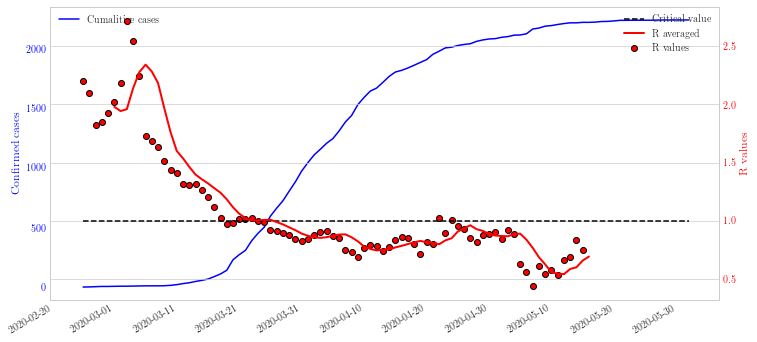

In [6]:
R.simulate(dt.datetime(2020, 2, 25), cum_positives[:first_wave_period], 15, 3)

## 2 SEIR(D)

The susceptible-exposed-infected-removed (SEIR) and susceptible-exposed-infected-recovered-deceased (SEIRD) compartmental epidemiological models are used for the simulation of the disease transmission under the following assumptions:
1. The observed population is closed - the total number of individuals in the population is fixed, vital dynamics are not taken into an account;
2. The population is well mixed and homogenous;
3. An exposed individual is infectious during the whole incubation period, the latent and infectious times of the pathogen are considered exponentially distributed.

The SEIR compartmental model is mathematically formulated using the following set of coupled ordinary difference equations:

$$
\begin{aligned}
\frac{S(t + \Delta t)}{\Delta t} &= -\frac{\beta \cdot S(t) \cdot I(t)}{N} - \delta \cdot S(t) \cdot E(t) \\
\frac{E(t + \Delta t)}{\Delta t} &= \frac{\beta \cdot S(t) \cdot I(t)}{N} - \alpha \cdot E(t) + \delta \cdot S(t) \cdot E(t) \\
\frac{I(t + \Delta t)}{\Delta t} &= \alpha \cdot E(t) - \gamma \cdot I(t) \\
\frac{R(t + \Delta t)}{\Delta t} &= \gamma \cdot I(t) \\
\end{aligned}
$$

where $N = S(t) + E(t) + I(t) + R(t)$.

$\beta$ stands for the contact (transmission) rate, the probability of the disease transmission between a susceptible and an infectious individual; $\delta$ could be considered as the rate of asymptomatic pathogen carriers; $\alpha$ represents the incubation rate of exposed individuals becoming infected; $\gamma$ is the recovery rate, which can be directly determined by the average duration of recovery, $\tau_d$, as follows:
$$
\gamma = \tau_d ^{-1}
$$

The SEIR compartmental model introduces additional segmentation of the removed compartment into two compartments - recovered and deceased compartment and thus makes more realistic approximation of the epidemiological situation. SEIRD is mathematically formulated using the following set of coupled ordinary difference equations:

$$
\begin{aligned}
\frac{S(t + \Delta t)}{\Delta t} &= -\frac{\beta \cdot S(t) \cdot I(t)}{N} - \delta \cdot S(t) \cdot E(t) \\
\frac{E(t + \Delta t)}{\Delta t} &= \frac{\beta \cdot S(t) \cdot I(t)}{N} - \alpha \cdot E(t) + \delta \cdot S(t) \cdot E(t) \\
\frac{I(t + \Delta t)}{\Delta t} &= \alpha \cdot E(t) - \gamma \cdot I(t) - \mu \cdot I(t) \\
\frac{R(t + \Delta t)}{\Delta t} &= \gamma \cdot I(t) \\
\frac{D(t + \Delta t)}{\Delta t} &= \mu \cdot I(t) \\
\end{aligned}
$$

where $N = S(t) + E(t) + I(t) + R(t) + D(t)$

Additional parameter in relation to SEIR model is $\mu$ which represent the death rate.

The following code shows how to determine $R_0$ using the CoroPy implementation of SEIR and SEIRD models for the first epidemiological wave. Following parameters need to be defined:
* `cum_positives` - cumulative number of confirmed positive infections;
* `cum_recovered` - cumulative number of recoveries;
* `cum_deceased` - cumulative number of deaths;
* `IC` - initial conditions for the set of ordinery difference equations describing the SEIR dynamics;
* `guess` - initial guess for the parameters to be fitted.

In [7]:
# initial conditions
S0 = cum_positives[first_wave_period-1] + cum_deceased[first_wave_period-1]
E0 = 10
I0 = 1
R0 = 0
D0 = 0
IC_seir = [S0, E0, I0, R0]
IC_seird = [S0, E0, I0, R0, D0]

### SEIR model without $\delta$

$R_0$ estimation method assuming the isolation of infected individuals:

$$
R_0 = \frac{\beta}{\alpha}
$$

In [8]:
def SEIR_no_delta(t, y, beta, alpha, gamma):
    S, E, I, R = y
    N = S + E + I + R
    return [
        -beta*S*I/N, 
        beta*S*I/N - alpha*E, 
        alpha*E - gamma*I, 
        gamma*I,
    ]

seir_model_no_delta = SEIRModel(ode_system=SEIR_no_delta)
params, loss = seir_model_no_delta.fit(
    cum_positives[:first_wave_period],
    cum_recovered[:first_wave_period],
    cum_deceased[:first_wave_period],
    IC_seir,
    guess=[0.1, 0.1, 0.1])

R0 = params[0]/(params[1])
print(f'\n [SEIR] <R0> = {round(R0, 4)}')

INFO:root:L-BFGS-B optimization started: 2020-10-14 13:37:06.167910
INFO:root:Elapsed time: 1.6013s

 [SEIR] <R0> = 2.244


### Extended SEIR model with $\delta$

$R_0$ estimation method assuming the isolation of infected individuals:

$$
R_0 = \frac{\beta}{\delta + \alpha}
$$

In [9]:
seir_model_extended = SEIRModel()
params, loss = seir_model_extended.fit(
    cum_positives[:first_wave_period],
    cum_recovered[:first_wave_period],
    cum_deceased[:first_wave_period],
    IC_seir,
    guess=[0.1, 0.1, 0.1, 0.1])

R0 = params[0]/(params[1] + params[2])
print(f'\n[SEIR extended] <R0> = {round(R0, 4)}')

INFO:root:L-BFGS-B optimization started: 2020-10-14 13:37:07.777829
INFO:root:Elapsed time: 35.6596s

[SEIR extended] <R0> = 2.1111


### SEIRD model without $\delta$

$R_0$ estimation method assuming the isolation of infected individuals:

$$
R_0 = \frac{\beta}{\alpha}
$$

In [10]:
# SEIRD model without delta parameter
def SEIRD_no_delta(t, y, beta, alpha, gamma, mu):
    S, E, I, R, D = y
    N = S + E + I + R + D
    return [
        -beta*S*I/N,
        beta*S*I/N - alpha*E,
        alpha*E - gamma*I - mu*I,
        gamma*I,
        mu*I,
    ]

seird_model_no_delta = SEIRDModel(ode_system=SEIRD_no_delta)
params, loss = seird_model_no_delta.fit(
    cum_positives[:first_wave_period],
    cum_recovered[:first_wave_period],
    cum_deceased[:first_wave_period],
    IC_seird,
    guess=[0.1, 0.1, 0.1, 0.1])

R0 = params[0]/(params[1])
print(f'\n[SEIRD] <R0> = {round(R0, 4)}')

INFO:root:L-BFGS-B optimization started: 2020-10-14 13:37:43.447830
INFO:root:Elapsed time: 3.7921s

[SEIRD] <R0> = 2.2011


### Extended SEIRD model with $\delta$

$R_0$ estimation method assuming the isolation of infected individuals:

$$
R_0 = \frac{\beta}{\delta + \alpha}
$$

In [11]:
seird_model_extended = SEIRDModel()
params, loss = seird_model_no_delta.fit(
    cum_positives[:first_wave_period],
    cum_recovered[:first_wave_period],
    cum_deceased[:first_wave_period],
    IC_seird,
    guess=[0.1, 0.1, 0.1, 0.1])

R0 = params[0]/(params[1] + params[2])
print(f'\n[SEIR] <R0> = {round(R0, 4)}')

INFO:root:L-BFGS-B optimization started: 2020-10-14 13:37:47.247884
INFO:root:Elapsed time: 3.7971s

[SEIR] <R0> = 2.2011


## 3 Empircal data-driven simplified estimate based on the number of confirmed positive infections in the initial exponential phase

If a single infectious individual makes $k$ contacts per day inside the susceptible population and the probability of disease transmission for each contact is defined as $p_i$, then $R_0$ can be mathematically formulated as 

$$
R_0 = k \cdot p_i \cdot \tau_i
$$

where $\tau_i$ is the expected infectious period. The product between $k$ and $p_i$ represents the transmission rate, $\beta$.

The outlined equation suggests two different ways of reducing $R_0$ and consequently the force of infection:
1. by **practicing social distancing** and **obeying epidemiological protective guidelines**, it is possible to decrease the number of secondary infections per unit time, $\beta$;
2. by **contact tracing** and **isolating potentially infectious indiviudals** as soon as possible, it is possible to decrease the infectious period, $\tau_i$.

For the sake of simplicity, the dynamic of infected/infectious individuals is considered only in the inital exponential phase. Underlying assumptions are the same as for previously outlined SEIR(D) models:

$$
I(t + \Delta t) = \beta \cdot \frac{I(t) \cdot S(t)}{N} \cdot \Delta t - \frac{1}{\tau_i} \cdot I(t) \cdot \Delta t
$$

Lets assume, for the sake of mathematical elegance, that the susceptible compartment is the same as the total population, $N$, at the beginning of the epidemics and the initial number of infected people is 1:

$$
I(t + \Delta t) \approx \Big(\beta - \frac{1}{\tau_i} \Big) \cdot I(t) \cdot \Delta t
$$

this yields to analytical solution:

$$
I(t) \approx \exp \Big( \big(\beta - \tau_i^{-1} \big) \cdot t \Big)
$$

The following code fits the number of active confirmed cases with the previous theretical consideration.
Parameters to be adjusted are:
* `tau_i` - the infectious period in days
* `k` - the average number of contacts per days

In [12]:
tau_i = 5.9
k = 5

In [13]:
def func(t, b):
    return np.exp((k*b - 1/tau_i)*t)

t = np.arange(30)
popt, pcov = curve_fit(func, t, active[:30], maxfev=10000)
p_i_exp = popt[0]
p_i_err = np.sqrt(np.diag(pcov))[0]

beta_95ci = np.array([
    (p_i_exp - p_i_err) * k,
    p_i_exp * k,
    (p_i_exp + p_i_err) * k,
])

R0 = beta_95ci * tau_i
print(f'\n<R0> = {round(R0[1], 4)}, 95% CI ({round(R0[0], 4)}, {round(R0[2], 4)})')


<R0> = 2.2779, 95% CI (2.2735, 2.2824)


## Results overview

|       **method**       | exected $R_0$ |                   95% CI                  |
|:----------------------:|:-------------:|:-----------------------------------------:|
|       brute force      |    $2.0862$   |            ($1.7715$, $2.4009$)           |
|  SEIR without $\delta$ |    $2.2440$   |                unavailable*               |
|      extended SEIR     |    $2.1111$   |                unavailable*               |
| SEIRD without $\delta$ |    $2.2011$   |                unavailable*               |
|     extended SEIRD     |    $2.2011$   |                unavailable*               |
|  empirical and data-driven |    $2.2779$   |            ($2.2735$, $2.2824$)           |
|                        |               | * due to the L-BFGS-B optimization method |